#### Import packages 

In [411]:
import pandas as pd
import geopandas as gpd
import numpy as np
from pysal.lib import weights
from splot.libpysal import plot_spatial_weights
from esda.moran import Moran, Moran_Local
from splot.esda import moran_scatterplot, plot_local_autocorrelation, lisa_cluster
import matplotlib.pyplot as plt
import folium
import matplotlib.colors as colors

#### Analysis region: Christchurch

<Axes: >

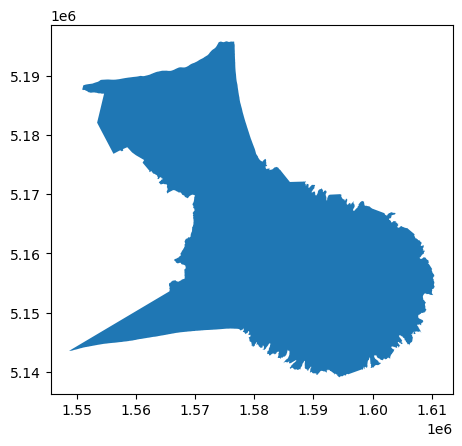

In [412]:
TA = gpd.read_file('GIS_file/territorial-authority-2021-generalised.gpkg')

chch = TA.loc[TA.TA2021_V1_00_NAME.str.contains('Christchurch'), :]

# buffer 1km
chch = chch

chch.plot()

In [413]:
# read in grid_1km_canterbury.shp
grid_1km = gpd.read_file('/home/ztang/canterbury_birds/Canterbury_birds/GIS_file/grid_1km_canterbury.shp').to_crs(2193)
grid_1km = grid_1km

In [414]:
grid_1km.crs

<Projected CRS: EPSG:2193>
Name: NZGD2000 / New Zealand Transverse Mercator 2000
Axis Info [cartesian]:
- N[north]: Northing (metre)
- E[east]: Easting (metre)
Area of Use:
- name: New Zealand - North Island, South Island, Stewart Island - onshore.
- bounds: (166.37, -47.33, 178.63, -34.1)
Coordinate Operation:
- name: New Zealand Transverse Mercator 2000
- method: Transverse Mercator
Datum: New Zealand Geodetic Datum 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

read in cbirds_gdf, this file merged with 1km grids already

In [415]:
# read in cbirds_gdf.gpkg
cbirds_gdf = gpd.read_file('/home/ztang/canterbury_birds/Canterbury_birds/GIS_file/cbirds_grid.gpkg')
cbirds_gdf.head()

CENTROID_X  CENTROID_Y        GridID  Shape_Leng  index_right  \
0   1382500.0   5022500.0  E13825N50225      4000.0        63830   
1   1378500.0   5027500.0  E13785N50275      4000.0        20725   
2   1378500.0   5027500.0  E13785N50275      4000.0        20443   
3   1378500.0   5027500.0  E13785N50275      4000.0        20723   
4   1378500.0   5027500.0  E13785N50275      4000.0        20713   

  last_edited_date         common_name                      locality  \
0       2024-01-02  New Zealand Falcon  Buster Diggings Mount Buster   
1       2024-07-12        Yellowhammer                         AN151   
2       2024-07-12             Dunnock                         AN151   
3       2024-07-12        Yellowhammer                         AN151   
4       2024-07-12        Yellowhammer                         AN151   

  migration_type  observation_count  month  \
0              N                  1      1   
1              N                  1      7   
2              N                  1      7   
3              N                  1      7   
4              N                  1      7   

                                            geometry  
0  MULTIPOLYGON (((1382000 5023000, 1383000 50230...  
1  MULTIPOLYGON (((1378000 5028000, 1379000 50280...  
2  MULTIPOLYGON (((1378000 5028000, 1379000 50280...  
3  MULTIPOLYGON (((1378000 5028000, 1379000 50280...  
4  MULTIPOLYGON (((1378000 5028000, 1379000 50280...

In [416]:
cbirds_gdf.columns

Index(['CENTROID_X', 'CENTROID_Y', 'GridID', 'Shape_Leng', 'index_right',
       'last_edited_date', 'common_name', 'locality', 'migration_type',
       'observation_count', 'month', 'geometry'],
      dtype='object')

try un sjoined birds data set to follow the lab material

In [417]:
cbird = pd.read_csv('/home/ztang/canterbury_birds/Canterbury_birds/GIS_file/cbirds_filtered.csv')
print(cbird.head())

  LAST EDITED DATE  TAXONOMIC ORDER CATEGORY          COMMON NAME  \
0       2023/01/11           6851.0     spuh        albatross sp.   
1       2023/01/11           6851.0     spuh        albatross sp.   
2       2023/12/11           7167.0  species  Australasian Gannet   
3       2023/01/18           7167.0  species  Australasian Gannet   
4       2023/10/17           7167.0  species  Australasian Gannet   

   SCIENTIFIC NAME EXOTIC CODE OBSERVATION COUNT BREEDING CODE  \
0  Diomedeidae sp.         NaN                 1           NaN   
1  Diomedeidae sp.         NaN                 4           NaN   
2   Morus serrator         NaN                 1           NaN   
3   Morus serrator         NaN                 1           NaN   
4   Morus serrator         NaN                 2           NaN   

  BREEDING CATEGORY BEHAVIOR CODE  ... ATLAS BLOCK  \
0               NaN           NaN  ...         NaN   
1               NaN           NaN  ...     blkCI59   
2               NaN       

In [418]:
cbird.columns

# covert columns to lower case
cbird.columns = cbird.columns.str.lower()


In [419]:
#Convert Lat/Long to geometry
cbird_chch = gpd.GeoDataFrame(cbird, geometry=gpd.points_from_xy(cbird.longitude, cbird.latitude), crs="EPSG:4326")\
.to_crs(2193).clip(chch)

Select useful cols and slipt date to month

In [420]:
cbird_chch.columns

Index(['last edited date', 'taxonomic order', 'category', 'common name',
       'scientific name', 'exotic code', 'observation count', 'breeding code',
       'breeding category', 'behavior code', 'state code', 'county',
       'county code', 'iba code', 'atlas block', 'locality', 'locality id',
       'locality type', 'latitude', 'longitude', 'observation date',
       'time observations started', 'approved', 'migration_type', 'geometry'],
      dtype='object')

In [421]:
# add underscore to column names
cbird_chch.columns = cbird_chch.columns.str.replace(' ', '_')

In [422]:
cbird_chch.head(3)

last_edited_date  taxonomic_order category        common_name  \
16366       2023/01/10           7432.0  species  White-faced Heron   
60903       2023/04/11           7609.0  species    Royal Spoonbill   
14123       2023/11/25           7224.0  species    Great Cormorant   

               scientific_name exotic_code observation_count breeding_code  \
16366  Egretta novaehollandiae         NaN                 1           NaN   
60903           Platalea regia         NaN                 6           NaN   
14123      Phalacrocorax carbo         NaN                 6           NaN   

      breeding_category behavior_code  ...  \
16366               NaN           NaN  ...   
60903               NaN           NaN  ...   
14123               NaN           NaN  ...   

                                                locality locality_id  \
16366  Lake Ellesmere (Te Waihora)--Outlet (observati...    L8565725   
60903  Lake Ellesmere (Te Waihora)--Outlet (observati...    L8565725   
14123  Lake Ellesmere (Te Waihora)--Outlet (observati...    L8565725   

      locality_type   latitude   longitude observation_date  \
16366             H -43.856127  172.375726       2023/01/10   
60903             H -43.856127  172.375726       2023/04/09   
14123             H -43.856127  172.375726       2023/01/08   

      time_observations_started approved  migration_type  \
16366                  18:12:00      1.0               N   
60903                  14:18:00      1.0               N   
14123                  11:42:00      1.0               N   

                              geometry  
16366  POINT (1549828.559 5143917.271)  
60903  POINT (1549828.559 5143917.271)  
14123  POINT (1549828.559 5143917.271)  

[3 rows x 25 columns]

In [423]:
# select only the columns we need 
cols = ['last_edited_date', 'common_name', 'locality', 'migration_type',
       'observation_count', 'geometry']

cbirds_chch = cbird_chch[cols]

# Ensure 'last_edited_date' is in datetime format
cbirds_chch['last_edited_date'] = pd.to_datetime(cbirds_chch.loc[:,'last_edited_date'])

# split the date to month column
cbirds_chch['month'] = cbirds_chch.loc[:,'last_edited_date'].dt.month

print(cbirds_chch.head())
print(cbirds_chch.dtypes)






      last_edited_date            common_name  \
16366       2023-01-10      White-faced Heron   
60903       2023-04-11        Royal Spoonbill   
14123       2023-11-25        Great Cormorant   
14703       2023-01-10  Little Pied Cormorant   
60270       2023-04-11              Kelp Gull   

                                                locality migration_type  \
16366  Lake Ellesmere (Te Waihora)--Outlet (observati...              N   
60903  Lake Ellesmere (Te Waihora)--Outlet (observati...              N   
14123  Lake Ellesmere (Te Waihora)--Outlet (observati...              N   
14703  Lake Ellesmere (Te Waihora)--Outlet (observati...              N   
60270  Lake Ellesmere (Te Waihora)--Outlet (observati...              N   

      observation_count                         geometry  month  
16366                 1  POINT (1549828.559 5143917.271)      1  
60903                 6  POINT (1549828.559 5143917.271)      4  
14123                 6  POINT (1549828.559 5143917.271)

/home/ztang/miniforge3/envs/deepl1/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/ztang/miniforge3/envs/deepl1/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [424]:
cbirds_chch.dtypes

last_edited_date     datetime64[ns]
common_name                  object
locality                     object
migration_type               object
observation_count            object
geometry                   geometry
month                         int32
dtype: object

In [425]:
cbirds_chch['observation_count'].unique()

array(['1', '6', '2', '17', '14', '9', '40', '20', '510', '78', '4',
       '115', '7', '3', '100', '24', '29', '8', '10', '80', '5', '11',
       '12', '15', '450', '237', '30', '16', '250', '281', '500', '294',
       '23', '26', '36', '19', '46', '21', '27', '13', '25', '39', '37',
       'X', '300', '34', '110', '42', '57', '67', '60', '54', '55', '111',
       '172', '71', '48', '150', '109', '18', '148', '547', '50', '28',
       '427', '967', '374', '267', '900', '22', '41', '1250', '211',
       '404', '523', '90', '470', '198', '51', '160', '140', '84', '38',
       '44', '31', '45', '97', '108', '32', '187', '127', '128', '33',
       '146', '76', '62', '400', '350', '35', '64', '47', '63', '56',
       '598', '200', '1150', '600', '52', '123', '186', '342', '105',
       '92', '70', '120', '53', '130', '75', '59', '58', '104', '85',
       '65', '43', '49', '61', '290', '800', '220', '650', '390', '380',
       '790', '230', '139', '66', '671', '247', '410', '126', '77', '15

In [426]:
cbirds_chch.loc[:,'observation_count'] = cbirds_chch['observation_count'].replace('X', '1')


In [427]:
# convert obersevation count to numeric and categorize the migration type
cbirds_chch['observation_count'] = cbirds_chch.loc[:,'observation_count'].astype('int')

cbirds_chch['migration_type'] = cbirds_chch.loc[:,'migration_type'].astype('category')

/home/ztang/miniforge3/envs/deepl1/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/ztang/miniforge3/envs/deepl1/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [428]:
cbirds_chch.dtypes

last_edited_date     datetime64[ns]
common_name                  object
locality                     object
migration_type             category
observation_count             int64
geometry                   geometry
month                         int32
dtype: object

In [429]:
cbirds_chch.head(3)

last_edited_date        common_name  \
16366       2023-01-10  White-faced Heron   
60903       2023-04-11    Royal Spoonbill   
14123       2023-11-25    Great Cormorant   

                                                locality migration_type  \
16366  Lake Ellesmere (Te Waihora)--Outlet (observati...              N   
60903  Lake Ellesmere (Te Waihora)--Outlet (observati...              N   
14123  Lake Ellesmere (Te Waihora)--Outlet (observati...              N   

       observation_count                         geometry  month  
16366                  1  POINT (1549828.559 5143917.271)      1  
60903                  6  POINT (1549828.559 5143917.271)      4  
14123                  6  POINT (1549828.559 5143917.271)     11

<Axes: >

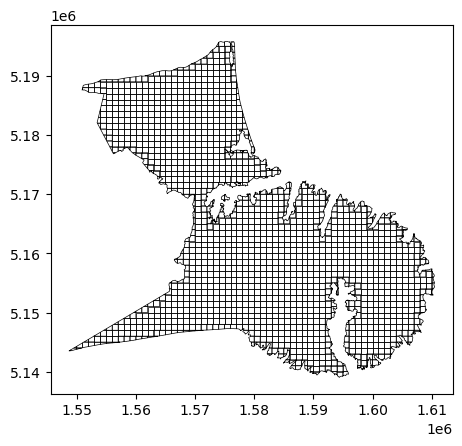

In [430]:
#Load SA2 shapefile and clip to Chch

unit = grid_1km.clip(chch)
# plot the unit and highlight the grid
unit.plot(edgecolor='black', facecolor='none', linewidth=0.5)



#### split the cbirds_gdf_new into two dataframes: nbirds and mbirds by migration_type

In [431]:
# split the cbirds_gdf_new into two dataframes: nbirds and mbirds by migration_type
nbirds = cbirds_chch[cbirds_chch['migration_type'] == 'N']
mbirds = cbirds_chch[cbirds_chch['migration_type'] == 'M']
print(nbirds.shape)
print(mbirds.shape)

(25571, 7)
(137, 7)


In [432]:
unit

CENTROID_X  CENTROID_Y        GridID  Shape_Leng  \
30720   1583500.0   5143500.0  E15835N51435      4000.0   
30728   1584500.0   5143500.0  E15845N51435      4000.0   
30729   1586500.0   5143500.0  E15865N51435      4000.0   
30722   1582500.0   5143500.0  E15825N51435      4000.0   
30727   1585500.0   5143500.0  E15855N51435      4000.0   
...           ...         ...           ...         ...   
33417   1575500.0   5194500.0  E15755N51945      4000.0   
33420   1576500.0   5195500.0  E15765N51955      4000.0   
33418   1574500.0   5195500.0  E15745N51955      4000.0   
33419   1575500.0   5195500.0  E15755N51955      4000.0   
32019   1582500.0   5174500.0  E15825N51745      4000.0   

                                                geometry  
30720  POLYGON ((1584000 5144000, 1584000 5143367.928...  
30728  POLYGON ((1585000 5144000, 1585000 5143000, 15...  
30729  POLYGON ((1587000 5144000, 1587000 5143000, 15...  
30722  MULTIPOLYGON (((1582014.17 5144000, 1582013.20...  
30727  POLYGON ((1586000 5144000, 1586000 5143000, 15...  
...                                                  ...  
33417  POLYGON ((1576000 5195000, 1576000 5194085.671...  
33420  GEOMETRYCOLLECTION (POLYGON ((1576002.532 5195...  
33418  POLYGON ((1575000 5195000, 1574000 5195000, 15...  
33419  GEOMETRYCOLLECTION (POLYGON ((1575862.75 51957...  
32019  MULTIPOLYGON (((1582049.513 5174271.072, 15820...  

[1734 rows x 5 columns]

In [433]:
cbirds_chch.head(3)

last_edited_date        common_name  \
16366       2023-01-10  White-faced Heron   
60903       2023-04-11    Royal Spoonbill   
14123       2023-11-25    Great Cormorant   

                                                locality migration_type  \
16366  Lake Ellesmere (Te Waihora)--Outlet (observati...              N   
60903  Lake Ellesmere (Te Waihora)--Outlet (observati...              N   
14123  Lake Ellesmere (Te Waihora)--Outlet (observati...              N   

       observation_count                         geometry  month  
16366                  1  POINT (1549828.559 5143917.271)      1  
60903                  6  POINT (1549828.559 5143917.271)      4  
14123                  6  POINT (1549828.559 5143917.271)     11

In [434]:
grid_1km.head(3)

CENTROID_X  CENTROID_Y        GridID  Shape_Leng  \
0   1395500.0   5004500.0  E13955N50045      4000.0   
1   1397500.0   5005500.0  E13975N50055      4000.0   
2   1398500.0   5005500.0  E13985N50055      4000.0   

                                            geometry  
0  POLYGON ((1395000 5005000, 1395673.839 5005000...  
1  POLYGON ((1397000 5006000, 1398000 5006000, 13...  
2  POLYGON ((1398000 5006000, 1398315.176 5006000...

#### Spatial join the Airbnb points data to the 1km grid.

In [489]:
from shapely import unary_union
# Spatial aggregation using spatial join

#Join airbnb to SA2 gpd and calculate median price for each SA2 unit
mbirds_nb = gpd.sjoin(mbirds, unit, how='right', predicate='intersects')\
.groupby(['GridID'])\
.agg(
    counts=("observation_count", "sum"),
    geometry = ('geometry', lambda x: unary_union(x)), 
    # convert an array of geometries into a single geometry object for each row
).reset_index() # reset the index of the resulting dataframe.

# convert pandas to geopandas
mbirds_nb = gpd.GeoDataFrame(mbirds_nb, geometry = mbirds_nb.geometry, crs = 2193)

mbirds_nb.head(5)



GridID  counts                                           geometry
0  E15485N51435     0.0  POLYGON ((1549000 5143536.473, 1548921.46 5143...
1  E15495N51435     2.0  POLYGON ((1550000 5143777.903, 1549929.362 514...
2  E15495N51445     0.0  POLYGON ((1550000 5144000, 1549519.453 5144000...
3  E15505N51435     0.0  POLYGON ((1550834.196 5144000, 1550760.49 5143...
4  E15505N51445     0.0  POLYGON ((1551000 5144053.528, 1550986.618 514...

In [436]:
# import geopandas as gpd
# import pandas as pd
# from shapely.ops import unary_union

# # Perform a spatial join between bird observations and the grid
# mbirds_nb = gpd.sjoin(nbirds, unit, how='right', predicate='intersects')

# # Ensure the geometry column is not dropped during aggregation
# # First, keep the geometries separate for aggregation
# geometries = mbirds_nb[['GridID', 'geometry']].copy()

# # Handle null geometries by filtering them out
# geometries = geometries[geometries['geometry'].notnull()]

# # Aggregate the 'observation_count', without touching the geometries for now
# agg_data = mbirds_nb.groupby('GridID').agg(
#     count=("observation_count", "sum")  # Summing up the observation counts
# ).reset_index()

# # Perform the unary union separately on the geometries
# geometry_agg = geometries.groupby('GridID').apply(
#     lambda x: unary_union(x['geometry'].tolist())
# ).reset_index(name='geometry')

# # Merge the aggregated data back with the geometries
# mbirds_nb = pd.merge(agg_data, geometry_agg, on='GridID')

# # Convert the final DataFrame back into a GeoDataFrame
# mbirds_nb = gpd.GeoDataFrame(mbirds_nb, geometry='geometry', crs=grid_1km.crs)

# # View the first 5 rows of the resulting GeoDataFrame
# mbirds_nb.head(5)


In [490]:
mbirds_nb['counts'].unique()

array([0.000e+00, 2.000e+00, 1.080e+02, 2.980e+02, 6.800e+01, 1.000e+00,
       4.200e+01, 2.400e+01, 5.000e+00, 4.000e+01, 1.600e+01, 6.900e+01,
       3.930e+02, 2.489e+03, 1.058e+03, 4.300e+01, 2.050e+02])

In [491]:
pd.isnull(mbirds_nb['counts']).sum()

0

In [492]:
mbirds_nb.head(3)

GridID  counts                                           geometry
0  E15485N51435     0.0  POLYGON ((1549000 5143536.473, 1548921.46 5143...
1  E15495N51435     2.0  POLYGON ((1550000 5143777.903, 1549929.362 514...
2  E15495N51445     0.0  POLYGON ((1550000 5144000, 1549519.453 5144000...

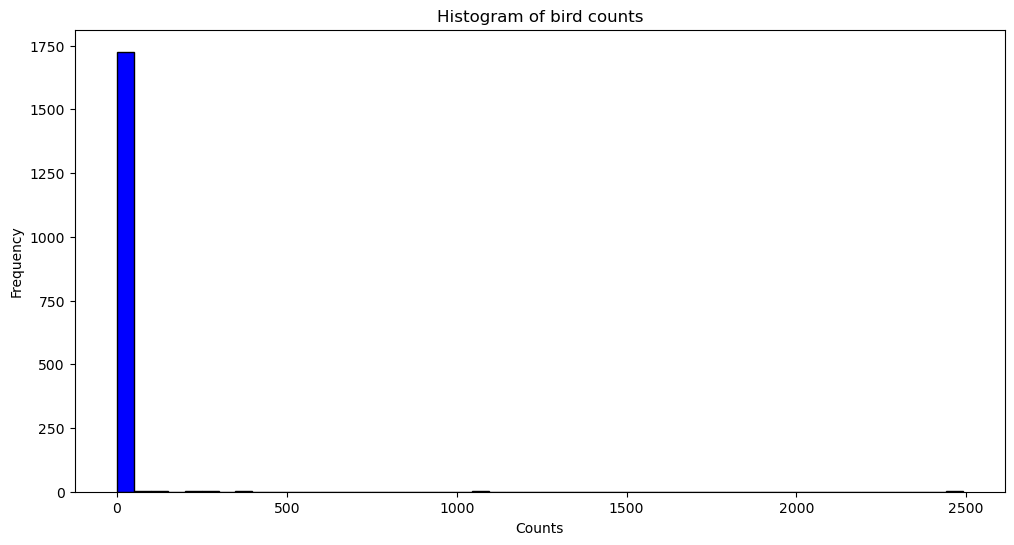

In [493]:
#use matplotlib to plot the histogram swith the x and y axis labels or rotate the x axis labels



plt.figure(figsize=(12,6))
plt.hist(mbirds_nb['counts'], bins=50, color='blue', edgecolor='black')
plt.title('Histogram of bird counts')
plt.xlabel('Counts')
plt.ylabel('Frequency')
plt.show()


In [494]:
# Plotting choropleth map of pop_count column
mbirds_nb.explore(
    tiles='cartodbpositron',
    column='counts',
    height='100%',
    width='100%',
    scheme='fisherjenks',
    k=10,
    cmap='Oranges',
    style_kwds={
        'stroke': True,
        'edgecolor': 'k',
        'linewidth': 0.03,
        'fillOpacity': 0.7
        },
    legend_kwds={
        'colorbar': False,
        'fmt': '{:.0f}'
        }
    )

/home/ztang/miniforge3/envs/deepl1/lib/python3.12/site-packages/folium/features.py:1159: UserWarning: GeoJsonTooltip is not configured to render for GeoJson GeometryCollection geometries. Please consider reworking these features: [{'GridID': 'E15755N51955', 'counts': 42.0, '__folium_color': '#fdd5ac'}, {'GridID': 'E15765N51955', 'counts': 0.0, '__folium_color': '#fff5eb'}] to MultiPolygon for full functionality.
https://tools.ietf.org/html/rfc7946#page-9
  warnings.warn(


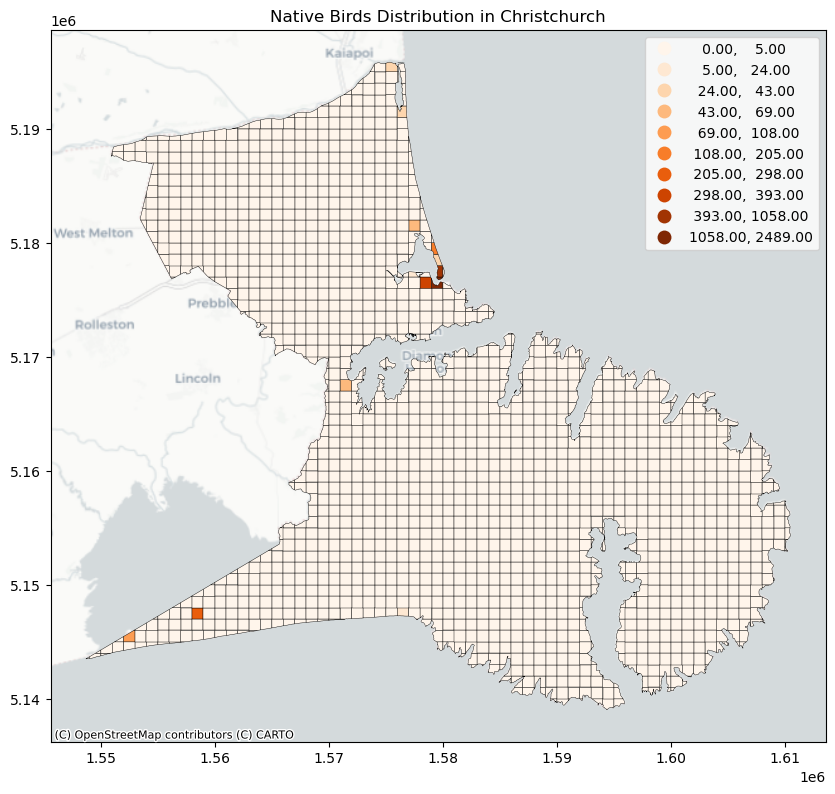

In [495]:
# map visualisation 

import matplotlib.pyplot as plt
import numpy as np

# add basemaps using `contextily`
import contextily as ctx

# initiate the map
fig, ax = plt.subplots(figsize=(10, 10))

# creating the map with 6 equak intervals - you can change these is you wish (https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html)
mbirds_nb.plot(column="counts", scheme='fisherjenks', k=10, cmap="Oranges", 
               edgecolor="black", linestyle="-", linewidth=0.3, 
               # plot the polygons with black and solid outlines
               missing_kwds={ "color": "lightgrey", "label": "Data not available"},
               # in case there are any areas with Nan - there shouldn't be in this plot but you may have some in your data if you reuse this code
               legend=True, ax=ax,)

# 

ax.set_title("Native Birds Distribution in Christchurch") # Set the title of each subplot

# add a basemap
ctx.add_basemap(ax, crs='epsg:2193', source=ctx.providers.CartoDB.Positron)

# show the plot
plt.show()

#### Spatial Autocorrelation

In [496]:
# Spatial similarity
import libpysal as lp

mbirds_nb = mbirds_nb.loc[~mbirds_nb.geom_type.isin(['Point', 'GeometryCollection']),:]
# remove Point and GeometryCollection in geometry otherwise get a TypeError

#Generate weights matrix - use_index = use index of df as ids to index the spatial weights object - we are not using this
wq =  weights.contiguity.Queen.from_dataframe(mbirds_nb, use_index=False)

#Row-standardise the weights
wq.transform = 'r'

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

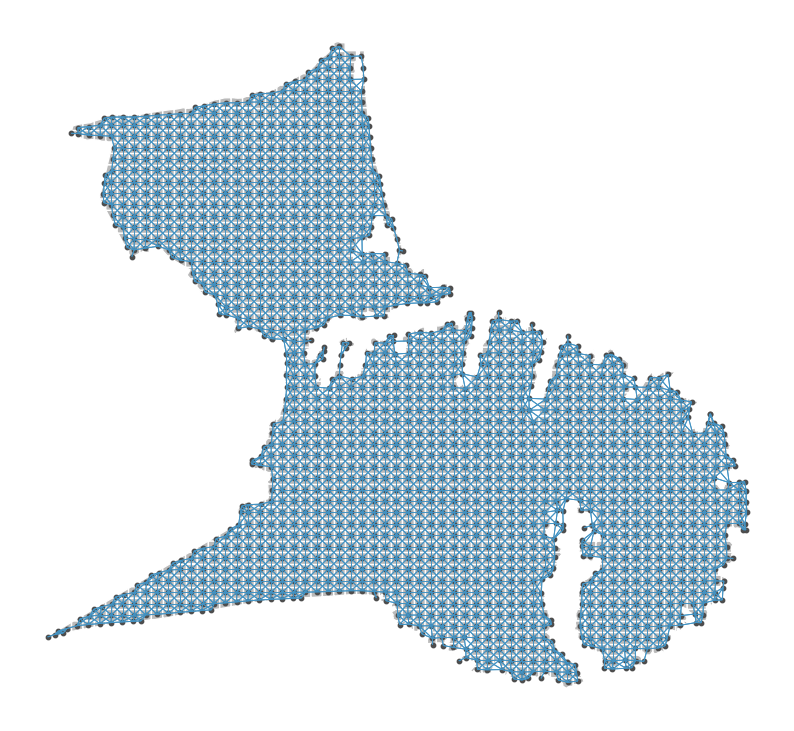

In [497]:
# Plotting to visualize spatial weights
plot_spatial_weights(wq, mbirds_nb)

### Quantifying Attribute Similarity using Spatial Lag

In [498]:

y = mbirds_nb['counts']
ylag = lp.weights.lag_spatial(wq, y)
ylag

array([2.        , 0.        , 0.66666667, ..., 0.        , 0.        ,
       0.        ])

In [499]:
import mapclassify as mc
ylagq5 = mc.Quantiles(ylag, k=5)

/home/ztang/miniforge3/envs/deepl1/lib/python3.12/site-packages/mapclassify/classifiers.py:1653: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 2.
  self.bins = quantile(y, k=k)


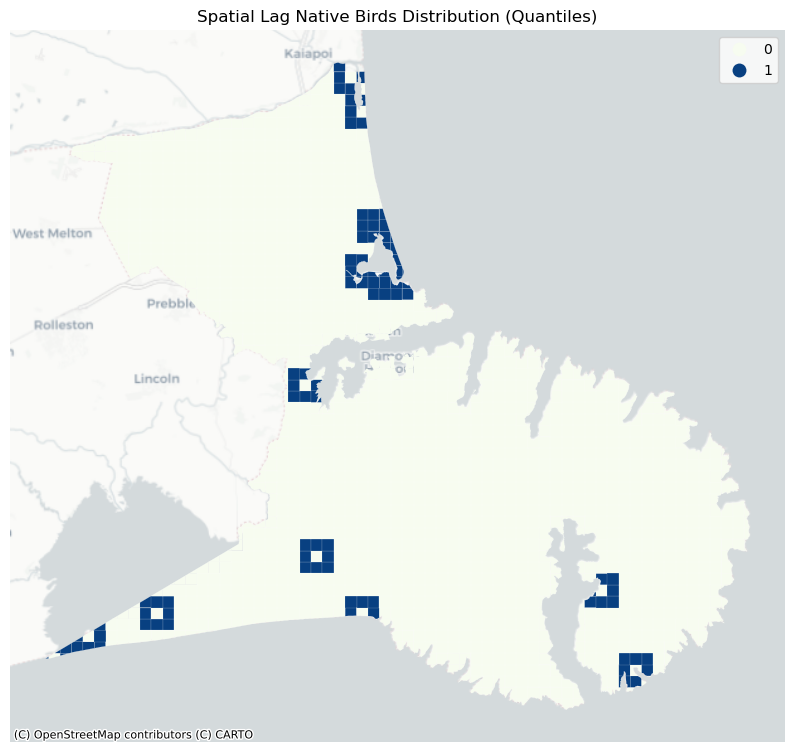

In [500]:
import contextily as ctx
f, ax = plt.subplots(1, figsize=(10, 10))
mbirds_nb.assign(cl=ylagq5.yb).plot(column='cl', categorical=True, \
        k=5, cmap='GnBu', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)

ax.set_axis_off()
plt.title("Spatial Lag Native Birds Distribution (Quantiles)")

# add a basemap
ctx.add_basemap(ax, crs='epsg:2193', source=ctx.providers.CartoDB.Positron)

plt.show()

In [501]:
mbirds_nb['lag_count'] = ylag

/home/ztang/miniforge3/envs/deepl1/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


/home/ztang/miniforge3/envs/deepl1/lib/python3.12/site-packages/mapclassify/classifiers.py:1653: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 2.
  self.bins = quantile(y, k=k)
/home/ztang/miniforge3/envs/deepl1/lib/python3.12/site-packages/mapclassify/classifiers.py:1653: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 2.
  self.bins = quantile(y, k=k)


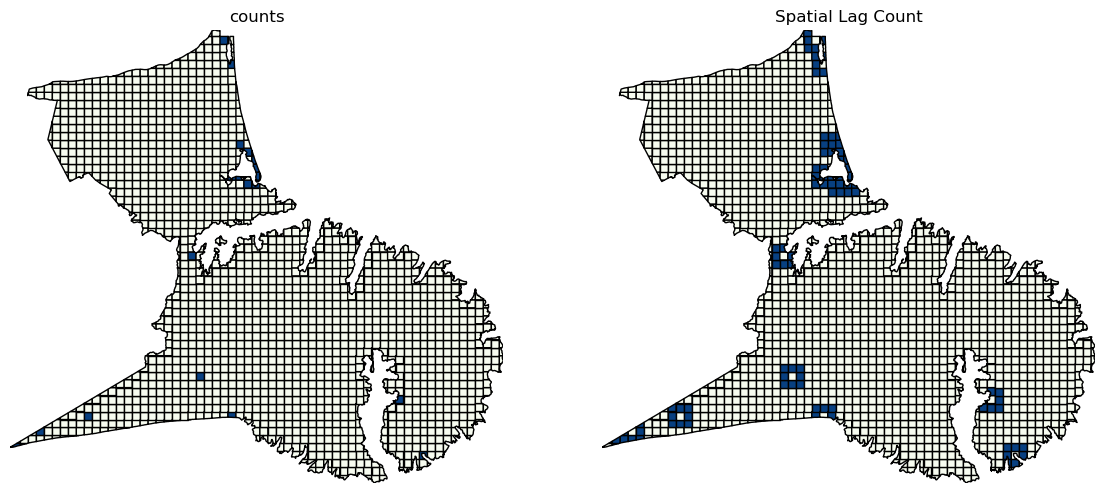

In [502]:
f,ax = plt.subplots(1,2,figsize=(14,14))
mbirds_nb.plot(column='counts', ax=ax[0], edgecolor='k',
        scheme="quantiles",  k=5, cmap='GnBu')
ax[0].axis(mbirds_nb.total_bounds[np.asarray([0,2,1,3])])
ax[0].set_title("counts")

mbirds_nb.plot(column='lag_count', ax=ax[1], edgecolor='k',
        scheme='quantiles', cmap='GnBu', k=5)
ax[1].axis(mbirds_nb.total_bounds[np.asarray([0,2,1,3])])
ax[1].set_title("Spatial Lag Count")
ax[0].axis('off')
ax[1].axis('off')
plt.show()

In [503]:
wq.weights

{0: [1.0],
 1: [0.25, 0.25, 0.25, 0.25],
 2: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333],
 3: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333],
 4: [0.25, 0.25, 0.25, 0.25],
 5: [1.0],
 6: [0.25, 0.25, 0.25, 0.25],
 7: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333],
 8: [0.25, 0.25, 0.25, 0.25],
 9: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333],
 10: [0.2, 0.2, 0.2, 0.2, 0.2],
 11: [0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285],
 12: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333],
 13: [0.2, 0.2, 0.2, 0.2, 0.2],
 14: [0.2, 0.2, 0.2, 0.2, 0.2],
 15: [0.2, 0.2, 0.2, 0.2, 0.2],
 16: [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125],
 17: [0.2, 0.2, 0.2, 0.2, 0.2],
 18: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333],
 19: [0.2, 0.2, 0.2, 0.2, 0.2],
 20: [0.2, 0.2, 0.2, 0.2, 0.2],
 21: [0

In [504]:
wq.neighbors

{0: [1],
 1: [0, 2, 3, 4],
 2: [1, 3, 4],
 3: [1, 2, 4],
 4: [1, 2, 3, 6],
 5: [8],
 6: [10, 11, 4, 7],
 7: [10, 11, 6],
 8: [9, 13, 5, 14],
 9: [8, 13, 14],
 10: [16, 6, 7, 11, 15],
 11: [16, 17, 6, 7, 10, 12, 15],
 12: [16, 17, 11],
 13: [22, 23, 8, 9, 14],
 14: [22, 23, 8, 9, 13],
 15: [16, 26, 25, 10, 11],
 16: [10, 11, 12, 15, 17, 25, 26, 27],
 17: [16, 27, 26, 11, 12],
 18: [32, 19, 31],
 19: [32, 33, 18, 20, 31],
 20: [32, 33, 34, 19, 21],
 21: [33, 34, 20],
 22: [37, 38, 23, 13, 14],
 23: [37, 38, 39, 22, 24, 13, 14],
 24: [23, 38, 39],
 25: [16, 40, 41, 26, 15],
 26: [40, 41, 42, 15, 16, 17, 25, 27],
 27: [16, 17, 26, 41, 42, 43, 28],
 28: [27, 42, 43],
 29: [46, 30, 47],
 30: [48, 31, 29, 46, 47],
 31: [32, 48, 49, 18, 19, 30, 47],
 32: [33, 48, 49, 18, 19, 20, 50, 31],
 33: [32, 34, 49, 50, 19, 20, 21, 51],
 34: [33, 50, 35, 51, 20, 21, 52],
 35: [34, 51, 52, 36, 53],
 36: [35, 52, 37, 53, 54],
 37: [36, 53, 38, 22, 23, 54, 55],
 38: [37, 39, 23, 22, 55, 24, 54, 56],
 39: [5

### Global spatial autocorrelation
Binary Case

In [505]:
y

0       0.0
1       2.0
2       0.0
3       0.0
4       0.0
       ... 
1729    0.0
1730    0.0
1731    0.0
1732    0.0
1733    0.0
Name: counts, Length: 1732, dtype: float64

In [506]:
y.median()

0.0

In [507]:
yb = y > y.median()
sum(yb)

19

In [508]:
yb = y > y.median()

#Replace the boolean values with 0 (False), 1 (True)
labels = ["0 Low", "1 High"]
yb = [labels[i] for i in 1*yb] 

#Add it as a column
mbirds_nb['yb'] = yb
mbirds_nb.head(5)

GridID  counts                                           geometry  \
0  E15485N51435     0.0  POLYGON ((1549000 5143536.473, 1548921.46 5143...   
1  E15495N51435     2.0  POLYGON ((1550000 5143777.903, 1549929.362 514...   
2  E15495N51445     0.0  POLYGON ((1550000 5144000, 1549519.453 5144000...   
3  E15505N51435     0.0  POLYGON ((1550834.196 5144000, 1550760.49 5143...   
4  E15505N51445     0.0  POLYGON ((1551000 5144053.528, 1550986.618 514...   

   lag_count      yb  
0   2.000000   0 Low  
1   0.000000  1 High  
2   0.666667   0 Low  
3   0.666667   0 Low  
4   0.500000   0 Low

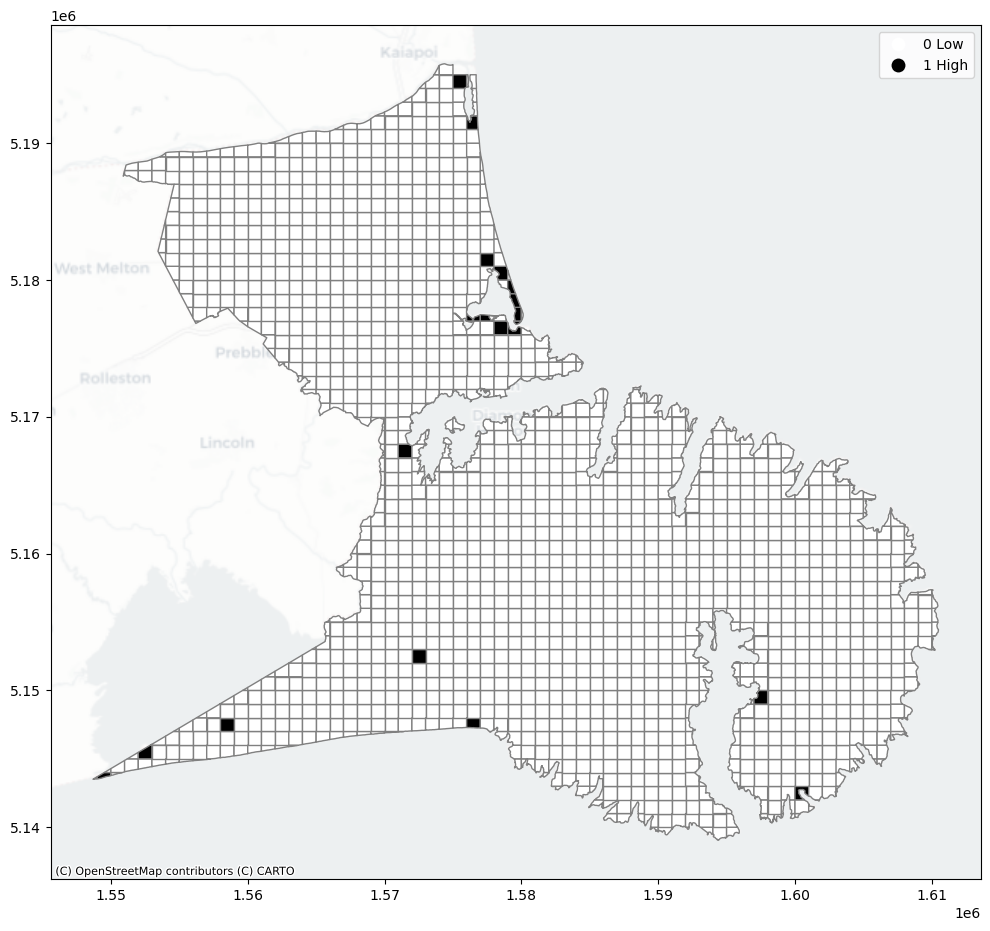

In [509]:
fig, ax = plt.subplots(figsize=(12,12), subplot_kw={'aspect':'equal'})
mbirds_nb.plot(column='yb', cmap='binary', edgecolor='grey', legend=True, ax=ax)

# add a basemap
ctx.add_basemap(ax, crs='epsg:2193', source=ctx.providers.CartoDB.Positron,alpha =0.4)

plt.show()

### Join counts

In [510]:
import esda 
yb = 1 * (y > y.median()) # convert back to binary - 0's and 1's
wq =  lp.weights.Queen.from_dataframe(mbirds_nb, use_index=False)

#Create a binary matrix, 'b'
wq.transform = 'b'
np.random.seed(66)

jc = esda.join_counts.Join_Counts(yb, wq)

In [511]:
jc.bb

8.0

In [512]:
jc.ww

6093.0

In [513]:
jc.bw

95.0

In [514]:
jc.bb + jc.ww + jc.bw

6196.0

In [515]:
wq.s0 / 2

6196.0

In [516]:
jc.bb

8.0

In [517]:
jc.mean_bb

0.6836836836836837

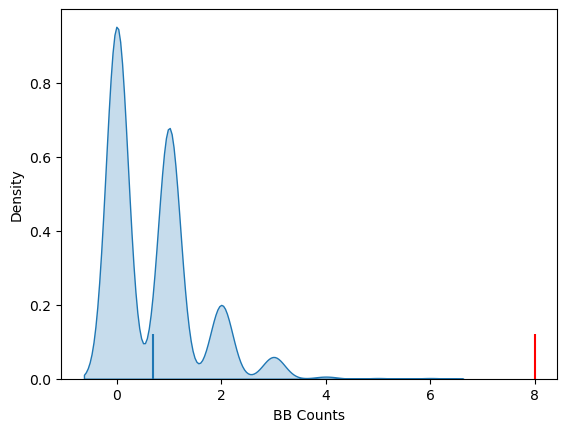

In [518]:
import seaborn as sbn
sbn.kdeplot(jc.sim_bb, fill=True)
plt.vlines(jc.bb, 0, .12, color='r')
plt.vlines(jc.mean_bb, 0,.12)
plt.xlabel('BB Counts')
plt.show()

In [519]:
jc.p_sim_bb

0.001

### Continuous Case

In [520]:
wq.transform = 'r'

In [521]:
#Set our variable of interest
y = mbirds_nb['counts']

In [522]:
np.random.seed(66)
mi = esda.moran.Moran(y, wq)
mi.I

0.21662278702437734

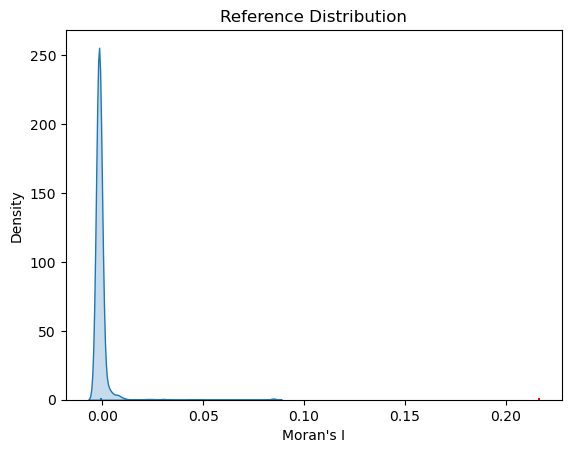

In [523]:
import seaborn as sbn
sbn.kdeplot(mi.sim, fill=True)
plt.vlines(mi.I, 0, 1, color='r')
plt.vlines(mi.EI, 0,1)
plt.xlabel("Moran's I")
plt.title('Reference Distribution')
plt.show()

In [524]:
mi.p_sim

0.001

### Local Autocorrelation: Moran’s Plot

In [525]:
#Transform the weights matrix back to row-standardised to calculate the spatial lag price
wq.transform = 'r'
lag_counts = lp.weights.lag_spatial(wq, mbirds_nb['counts'])

In [473]:
# counts = mbirds_nb['counts']

# #create a straight line of best fit for the association between price and lag price (sort of a linear regression)
# #a = intercept, b= slope
# b, a = np.polyfit(price, lag_price, 1)

# f, ax = plt.subplots(1, figsize=(12, 12))

# #Plot the points
# plt.plot(price, lag_price, '.', color='firebrick')

# # Split the plot into quadrants
# #dashed vert at mean of the price
# plt.vlines(price.mean(), lag_price.min(), lag_price.max(), linestyle='--')
# # dashed horizontal at mean of lagged price 
# plt.hlines(lag_price.mean(), price.min(), price.max(), linestyle='--')

# # red line of best fit using global I as slope
# plt.plot(price, a + b*price, 'r')
# plt.title('Moran Scatterplot')
# plt.ylabel('Spatial Lag of Price')
# plt.xlabel('Price')

# # Label quadrants
# plt.text(200, 170, "hotspot", fontsize=10)
# plt.text(200, 100, "diamond", fontsize=10)
# plt.text(30, 170, "doughnut", fontsize=10)
# plt.text(30, 100, "coldspot", fontsize=10)
# plt.show()

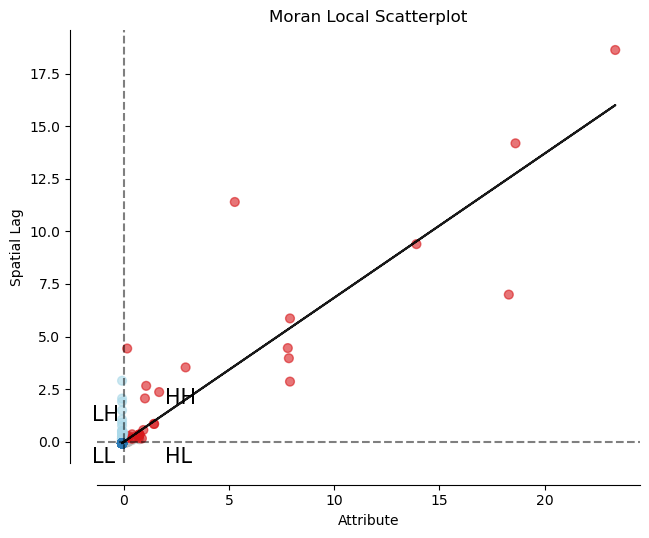

In [526]:
# Local Moran's I
local_moran = Moran_Local(lag_counts, wq)

# Plotting Local Moran's I scatterplot of pop_count
fig, ax = moran_scatterplot(local_moran, p=0.05);

plt.text(1.95, 1.8, 'HH', fontsize=15)
plt.text(1.95, -1.0, 'HL', fontsize=15)
plt.text(-1.5, 1, 'LH', fontsize=15)
plt.text(-1.5, -1, 'LL', fontsize=15)
plt.show()

In [527]:
li = esda.moran.Moran_Local(y, wq)
li.q

array([3, 3, 3, ..., 3, 3, 3])

In [528]:
(li.p_sim < 0.05).sum()

1673

### Hot Spots, Cold Spots, Doughnuts and Diamonds

In [529]:
#Create a pandas series of booleans for SA2 areas with p-values < 0.05 for each of the 4 quadrants
sig = li.p_sim < 0.05
hotspot = sig * li.q==1
coldspot = sig * li.q==3
doughnut = sig * li.q==2
diamond = sig * li.q==4

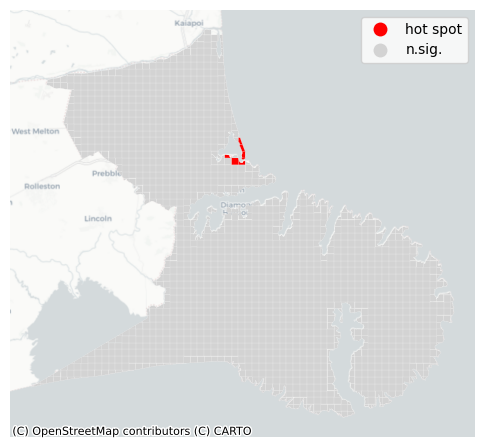

In [530]:
#Label each Hotspot
spots = ['n.sig.', 'hot spot']
labels = [spots[i] for i in hotspot*1]

df = mbirds_nb

from matplotlib import colors
hmap = colors.ListedColormap(['red', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(6, 6))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()

# add a basemap
ctx.add_basemap(ax, crs='epsg:2193', source=ctx.providers.CartoDB.Positron)

plt.show()

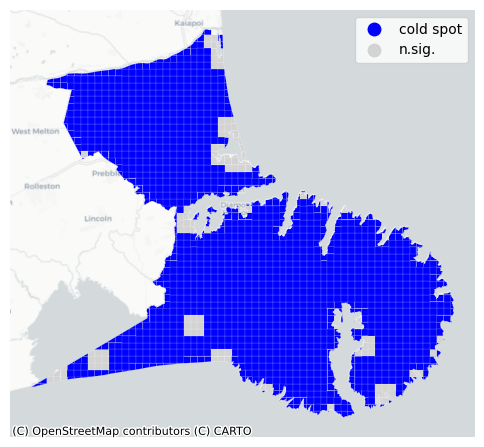

In [531]:
#Label each Cold spot
spots = ['n.sig.', 'cold spot']
labels = [spots[i] for i in coldspot*1]

df = mbirds_nb

from matplotlib import colors
hmap = colors.ListedColormap(['blue', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(6, 6))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()

# add a basemap
ctx.add_basemap(ax, crs='epsg:2193', source=ctx.providers.CartoDB.Positron)

plt.show()

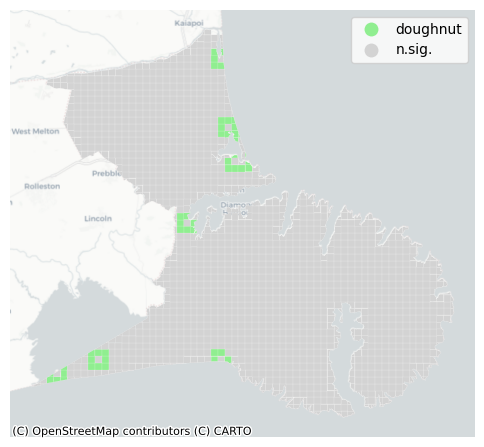

In [532]:
#Label each doughnut
spots = ['n.sig.', 'doughnut']
labels = [spots[i] for i in doughnut*1]

df = df

from matplotlib import colors
hmap = colors.ListedColormap(['lightgreen', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(6, 6))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()

# add a basemap
ctx.add_basemap(ax, crs='epsg:2193', source=ctx.providers.CartoDB.Positron)
plt.show()

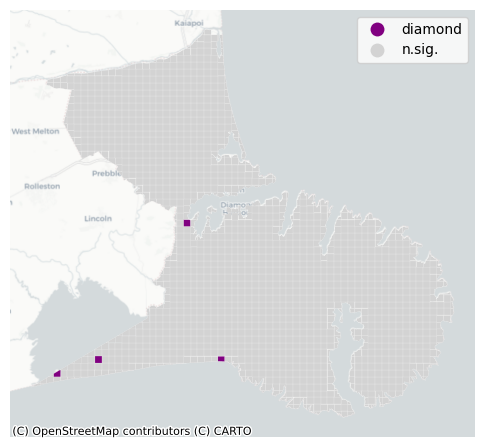

In [533]:
#Label each diamond
spots = ['n.sig.', 'diamond']
labels = [spots[i] for i in diamond*1]

df = mbirds_nb
from matplotlib import colors
hmap = colors.ListedColormap(['purple', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(6, 6))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()

# add a basemap
ctx.add_basemap(ax, crs='epsg:2193', source=ctx.providers.CartoDB.Positron)
plt.show()

In [534]:
#Create an array for SA2 areas with p-values < 0.05 for all 4 quadrants combined
sig = 1 * (li.p_sim < 0.05)
hotspot = 1 * (sig * li.q==1)
coldspot = 3 * (sig * li.q==3)
doughnut = 2 * (sig * li.q==2)
diamond = 4 * (sig * li.q==4)
spots = hotspot + coldspot + doughnut + diamond
spots

array([3, 3, 3, ..., 3, 3, 3])

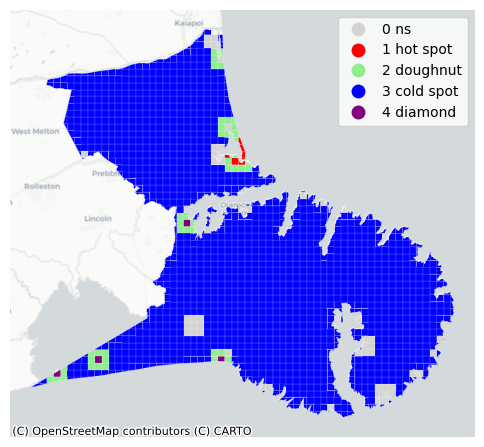

In [535]:
#Label each value in the array
spot_labels = [ '0 ns', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']
labels = [spot_labels[i] for i in spots] 

from matplotlib import colors
hmap = colors.ListedColormap([ 'lightgrey', 'red', 'lightgreen', 'blue', 'purple'])
f, ax = plt.subplots(1, figsize=(6, 6))
mbirds_nb.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()

# add a basemap
ctx.add_basemap(ax, crs='epsg:2193', source=ctx.providers.CartoDB.Positron)
plt.show()

#### Spatial clustering and regionalisation
##### Clustering using KMeans from sklearn

In [536]:
import libpysal
from sklearn.cluster import KMeans, AgglomerativeClustering

wq = libpysal.weights.Queen.from_dataframe(mbirds_nb, use_index=False)

kmeans = KMeans(n_clusters=5, n_init=10)

import numpy
numpy.random.seed(66)
cluster_variables = ['counts']
k5cls = kmeans.fit(mbirds_nb[cluster_variables])

print(k5cls.labels_)

# Assign labels into a column
mbirds_nb['k5cls'] = k5cls.labels_

[0 0 0 ... 0 0 0]


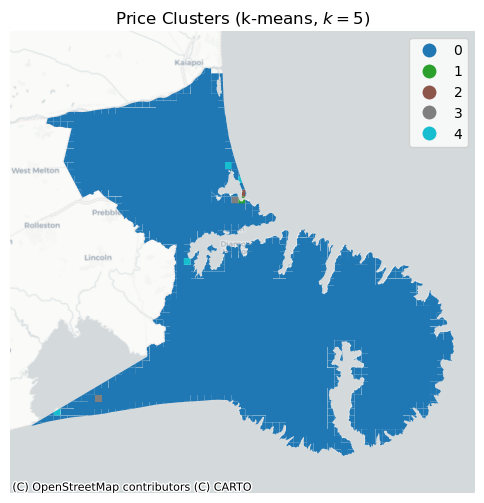

In [537]:
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot unique values choropleth including a legend and with no boundary lines
mbirds_nb.plot(column='k5cls', categorical=True, legend=True, linewidth=0, ax=ax)
# Remove axis
ax.set_axis_off()
# Keep axes proportionate
plt.axis('equal')
# Add title
plt.title(r'Price Clusters (k-means, $k=5$)')

# add a basemap
ctx.add_basemap(ax, crs='epsg:2193', source=ctx.providers.CartoDB.Positron)
# Display the map
plt.show()

k5cls
0    1724
1       1
2       1
3       2
4       4
dtype: int64
k5cls
0    1477.467399
1       0.529281
2       0.475382
3       1.994896
4       3.101477
dtype: float64
       counts                                                            \
        count         mean        std     min      25%     50%      75%   
k5cls                                                                     
0      1724.0     0.079466   1.581618     0.0     0.00     0.0     0.00   
1         1.0  2489.000000        NaN  2489.0  2489.00  2489.0  2489.00   
2         1.0  1058.000000        NaN  1058.0  1058.00  1058.0  1058.00   
3         2.0   345.500000  67.175144   298.0   321.75   345.5   369.25   
4         4.0   112.500000  64.417906    68.0    68.75    88.5   132.25   

               
          max  
k5cls          
0        43.0  
1      2489.0  
2      1058.0  
3       393.0  
4       205.0  


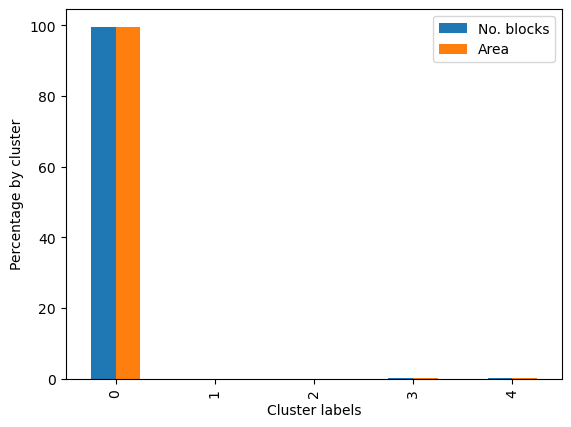

In [538]:
# Group data table by cluster label and count observations
k5sizes = mbirds_nb.groupby("k5cls").size()
print(k5sizes)

# Dissolve areas by Cluster, aggregate by summing,
areas = mbirds_nb.dissolve(by="k5cls", aggfunc="sum").geometry.area/10**6
print(areas)

# Group table by cluster label, keep the variables used for clustering, and obtain their mean
k5means = mbirds_nb.groupby("k5cls")[cluster_variables].mean()
# Transpose the table and print it rounding each value to three decimals
k5means.T.round(3)

# Use describe() to obtain more detailed profiles
k5desc = mbirds_nb.groupby('k5cls')[cluster_variables].describe()
print(k5desc)

##  Create a bar plot for the number of blocks and areas covered in each cluster
# Bind cluster figures in a single table
area_blocks = pd.DataFrame({"No. blocks": k5sizes, "Area": areas})
# Convert raw values into percentages
area_blocks = area_blocks * 100 / area_blocks.sum()
# Bar plot
ax = area_blocks.plot.bar()
# Rename axes
ax.set_xlabel("Cluster labels")
ax.set_ylabel("Percentage by cluster");

### Regionalization: spatially constrained clustering using AgglomerativeClustering

In [539]:
from sklearn.cluster import AgglomerativeClustering

numpy.random.seed(123456)
model = AgglomerativeClustering(linkage='ward',
                                connectivity=wq.sparse,
                                n_clusters=5)
model.fit(mbirds_nb[cluster_variables])


AgglomerativeClustering(connectivity=<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 12392 stored elements and shape (1732, 1732)>,
                        n_clusters=5)

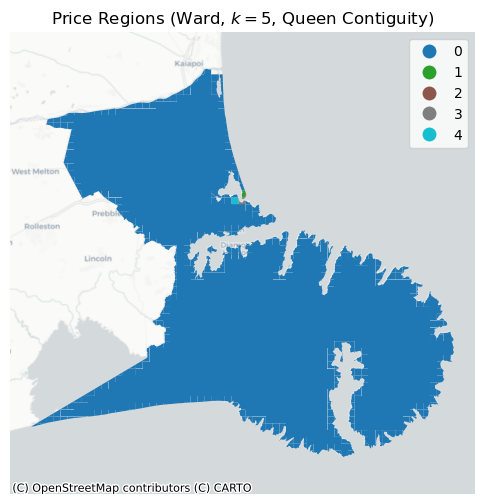

In [540]:
mbirds_nb['ward5wq'] = model.labels_

# Setup figure and ax
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot unique values choropleth including a legend and with no boundary lines
mbirds_nb.plot(column='ward5wq', categorical=True, legend=True, linewidth=0, ax=ax)
# Remove axis
ax.set_axis_off()
# Keep axes proportionate
plt.axis('equal')
# Add title
plt.title(r'Price Regions (Ward, $k=5$, Queen Contiguity)')

# add a basemap
ctx.add_basemap(ax, crs='epsg:2193', source=ctx.providers.CartoDB.Positron)
# Display the map
plt.show()